# APMTH 207: Advanced Scientific Computing: 
## Stochastic Methods for Data Analysis, Inference and Optimization
## Homework #6
**Harvard University**<br>
**Spring 2018**<br>
**Instructors: Rahul Dave**<br>
**Due Date: ** Friday, March 9th, 2018 at 11:00am

**Instructions:**

- Upload your iPython notebook containing all work to Canvas.

- Structure your notebook and your work to maximize readability.

## Problem 1: Metropolis and Chill

Suppose we ask you to memorize the order of the top five movies on IMDB. When we quiz you on the order afterwards, you might not recall the correct order, but the mistakes you will tend to make in your recall can be modeled by simple probabilistic models.
  
Let's say that the top five movies are:  
1. *The Shawshank Redemption*
2. *The Godfather*
3. *Wonder Woman*
4. *Black Panther*
5. *Pulp Fiction*

Let's represent this ordering by the vector $\omega = (1,2,3,4,5)$. 

If you were to mistakenly recall the top five movies as:
2. *The Godfather*
3. *Wonder Woman*
5. *Pulp Fiction*
4. *Black Panther*
1. *The Shawshank Redemption*

We'd represent your answer by the vector $\theta = (2,3,5,4,1)$.

Now, we have a way of quantifying how wrong your answer can be. We define the Hamming distance between two top five rankings, $\theta, \omega$, as follows:
$$d(\theta, \omega) = \sum_{i=1}^5 \mathbb{I}_{\theta_i\neq \omega_i},$$ 
where $\mathbb{I}_{\theta_i\neq \omega_i}$ is the indicator function that returns 1 if $\theta_i\neq \omega_i$, and 0 otherwise.

For example, the Hamming distance between your answer and the correct answer is $d(\theta, \omega)=4$, because you only ranked *Black Panther* in both answers correctly. 

Finally, let's suppose that the probability of giving a particular answer (expressed as $\theta$) is modeled as
$$ p(\theta \,|\, \omega, \lambda) \propto  e^{-\lambda\, d(\theta,\, \omega)}.$$

### Part A:

Implement an Metropolis algorithm to produce sample guesses from 500 individuals, with various $\lambda$ values, $\lambda=0.2, 0.5, 1.0$. What are the top five possible guesses?

### Part B:
Using the Metropolis algorithm, compute the probability that *The Shawshank Redemption* is ranked as the top movie (ranked number 1) . Compare the resulting probabilities for the various different $\lambda$ values. Summarize your findings.

## Solution

### Parts A and B

In [1]:
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def Hamming_distance(theta, omega):
    distance = np.sum(theta != omega)
    return distance

In [3]:
def answer_pdf(theta, lam):
    omega = np.array([1, 2, 3, 4, 5])
    pdf = np.exp(-lam * Hamming_distance(theta, omega))
    return pdf

In [4]:
def qdraw():
    sequence = np.array([1, 2, 3, 4, 5])
    draw = np.random.choice(sequence, size=5, replace=False)
    return draw

In [5]:
def metropolis(lam, p, qdraw, nsamp, xinit):
    samples = np.empty((nsamp, 5))
    x_prev = xinit
    for i in range(nsamp):
        x_star = qdraw()
        p_star = p(x_star, lam)
        p_prev = p(x_prev, lam)
        pdfratio = p_star/p_prev
        if np.random.uniform() < min(1, pdfratio):
            samples[i,:] = x_star
            x_prev = x_star
        else:#we always get a sample
            samples[i,:] = x_prev
            
    return samples

In [6]:
nsamp = 500
lams = np.array([0.2, 0.5, 1.0])
xinit = np.array([1, 2, 3, 4, 5])

In [7]:
for lam in lams:
    samples = metropolis(lam, answer_pdf, qdraw, nsamp, xinit)
    (samples_unique, samples_counts) = np.unique(samples, axis=0, return_counts=True)
    top5_index = np.argsort(samples_counts)[-5:][::-1]
    samples_top5 = samples_unique[top5_index]
    prob = np.sum(samples[:,0] == 1) / nsamp
    print('lambda = ', lam)
    print('top 5 guesses:')
    print(samples_top5)
    print('The probability that The Shawshank Redemption is ranked as the top movie is ', prob)
    print('******')

lambda =  0.2
top 5 guesses:
[[ 1.  2.  3.  5.  4.]
 [ 4.  2.  3.  1.  5.]
 [ 3.  2.  1.  5.  4.]
 [ 4.  2.  5.  3.  1.]
 [ 5.  2.  4.  1.  3.]]
The probability that The Shawshank Redemption is ranked as the top movie is  0.196
******
lambda =  0.5
top 5 guesses:
[[ 1.  2.  3.  4.  5.]
 [ 1.  4.  3.  2.  5.]
 [ 1.  2.  5.  4.  3.]
 [ 5.  2.  3.  4.  1.]
 [ 4.  2.  1.  5.  3.]]
The probability that The Shawshank Redemption is ranked as the top movie is  0.296
******
lambda =  1.0
top 5 guesses:
[[ 1.  2.  3.  4.  5.]
 [ 1.  2.  5.  4.  3.]
 [ 1.  3.  4.  2.  5.]
 [ 4.  2.  3.  1.  5.]
 [ 1.  2.  5.  3.  4.]]
The probability that The Shawshank Redemption is ranked as the top movie is  0.616
******


As the value of $\lambda$ increases, the top 5 guesses are more similar to the actual ranking and the probability that The Shawshank Redemption is ranked as the top movie also increases. 

## Problem 2: Lensed Galaxies via Metropolis-Hastings

You are a renowned observational astronomer working on gravitational lensing and you just got news about a source whose morphology appears distorted, most likely because there is a foreground source (an ensemble of mini black holes for which you know the mass and position) acting as a lens. Your gravitational lensing calculations indicate that the detected flux $F$ from the background source as a function of right ascencion ($x$) and declination ($y$) can be described by a modified Beale's function:

$F(x,y) = \exp\left[-\left(\frac{x^2}{2\sigma_x^2}+\frac{y^2}{2\sigma_y^2}\right)\right] \log (1.0+(1.5-x+xy)^2+(2.25-x+xy^2)^2+(2.625-x+xy^3)^2) $

with $\sigma_x = \sigma_y = \sqrt{10}$

You are interested in observing this source with the Hubble Space Telescope, and you want to simulate beforehand how photons will form the image on the Hubble detector. You realize that a good way to do this is by sampling F(x,y) with a Monte Carlo method.

### Part A:

Using the following asymmetric function as a proposal distribution:

$q(x,y) = \frac{1}{\sqrt{2 \pi \gamma_1\gamma_2}} {\rm exp}\left[-\left(\frac{(x-0.1)^2}{2 \gamma_1^2} + \frac{(y-0.1)^2}{2 \gamma_2^2}\right) \right] $ 

with $\gamma_1 = 1.0\beta$, $\gamma_2 = 1.5\beta$, and $\beta=1$ (x and y are the coordinates of the proposed step if we center the coordinate system in our current position.)

construct a Metropolis-Hastings algorithm to produce $N=100,000$ samples from $F(x,y)$ with an initial position of $(x,y) = (5,-5)$. Plot the results.

### Part B:

We want to experiment with $\beta$ by running your code with $\beta$ in the range 0.1 to 40 (think about the appropriate order of magnitude of the $\beta$ spacing). 

1. Plot the accepted sample histories for each $\beta$. What is the acceptance rate for each $\beta$? 
2. Explain your results and select the "best" value of $\beta$?

### Part C:

Choose a symmetric proposal and construct a Metropolis algorithm to product $N=100,000$ samples from $F(x,y)$ with an initial position of $(x,y) = (5,-5)$. Plot the results.  How do the results compare to those from Metropolis-Hastings in **Parts A & B**?  

## Solution

### Part A

In [8]:
beta = 1
t = 0.1
sigmax = np.sqrt(10)
sigmay = np.sqrt(10)
nsamp = 100000
xinit = np.array([5, -5])

In [9]:
def F(x, y):
    exp = np.exp(- (x**2 / (2 * sigmax**2) + y**2 / (2 * sigmay**2)))
    log = np.log10(1 + (1.5 - x + x * y)**2 + (2.25 - x + x * y**2)**2 + (2.625 - x + x * y**3)**2)
    return exp * log

In [10]:
def qdraw(x, beta):
    gamma1 = beta
    gamma2 = 1.5 * beta
    Sigma = np.array([[gamma1**2, 0], [0, gamma2**2]])
    draw = np.random.multivariate_normal(mean=x + t, cov=Sigma, size=1)
    return draw

In [11]:
def q(x_star, x_prev, beta):
    gamma1 = beta
    gamma2 = 1.5 * beta
    Sigma = np.array([[gamma1**2, 0], [0, gamma2**2]])
    pdf = multivariate_normal.pdf(x_star, mean=x_prev + t, cov=Sigma)
    return pdf

In [12]:
def metropolis_hastings(p, q, qdraw, nsamp, xinit, beta):
    samples = np.empty((nsamp, 2))
    x_prev = xinit
    accepted = 0
    for i in range(nsamp):
        x_star = qdraw(x_prev, beta).reshape(2)
        p_star = p(x_star[0], x_star[1])
        p_prev = p(x_prev[0], x_prev[1])
        pdfratio = p_star/p_prev
        proposalratio = q(x_prev, x_star, beta) / q(x_star, x_prev, beta)
        if np.random.uniform() < min(1, pdfratio*proposalratio):
            samples[i,:] = x_star
            x_prev = x_star
            accepted +=1
        else:#we always get a sample
            samples[i,:] = x_prev
            
    return samples, accepted

In [13]:
MH_samples, accepted = metropolis_hastings(F, q, qdraw, nsamp, xinit, beta)

In [14]:
x = np.linspace(-15, 15)
y = np.linspace(-15, 15)
X, Y = np.meshgrid(x, y)
Z = F(X, Y)

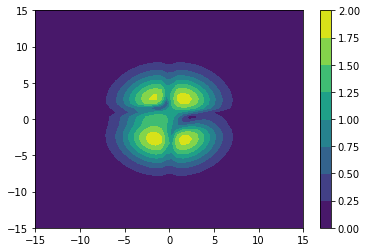

In [15]:
plt.contourf(X, Y, Z)
plt.colorbar()
plt.show()

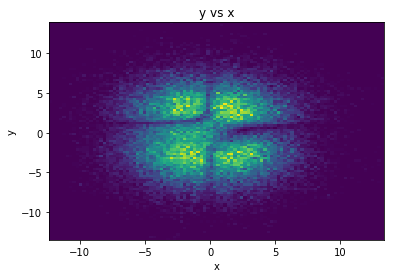

In [16]:
plt.hist2d(MH_samples[:,0], MH_samples[:,1], bins=100)
plt.xlabel('x')
plt.ylabel('y')
plt.title('y vs x')
plt.show()

In [17]:
accep_rate = accepted / nsamp
print('Acceptance Rate = ', accep_rate)

Acceptance Rate =  0.75951


### Part B

In [29]:
betas = np.array([0.1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 20, 25, 30, 40])
nsamp = 100000

beta =  0.1 , acceptance rate =  0.22624
beta =  1.0 , acceptance rate =  0.76137
beta =  2.0 , acceptance rate =  0.63457
beta =  3.0 , acceptance rate =  0.52911
beta =  4.0 , acceptance rate =  0.42912
beta =  5.0 , acceptance rate =  0.34962
beta =  6.0 , acceptance rate =  0.28537
beta =  7.0 , acceptance rate =  0.23467
beta =  8.0 , acceptance rate =  0.19407
beta =  9.0 , acceptance rate =  0.16321
beta =  10.0 , acceptance rate =  0.13595
beta =  11.0 , acceptance rate =  0.11763
beta =  12.0 , acceptance rate =  0.10298
beta =  13.0 , acceptance rate =  0.08809
beta =  14.0 , acceptance rate =  0.07701
beta =  15.0 , acceptance rate =  0.06791
beta =  20.0 , acceptance rate =  0.04042
beta =  25.0 , acceptance rate =  0.02579
beta =  30.0 , acceptance rate =  0.01871
beta =  40.0 , acceptance rate =  0.01075


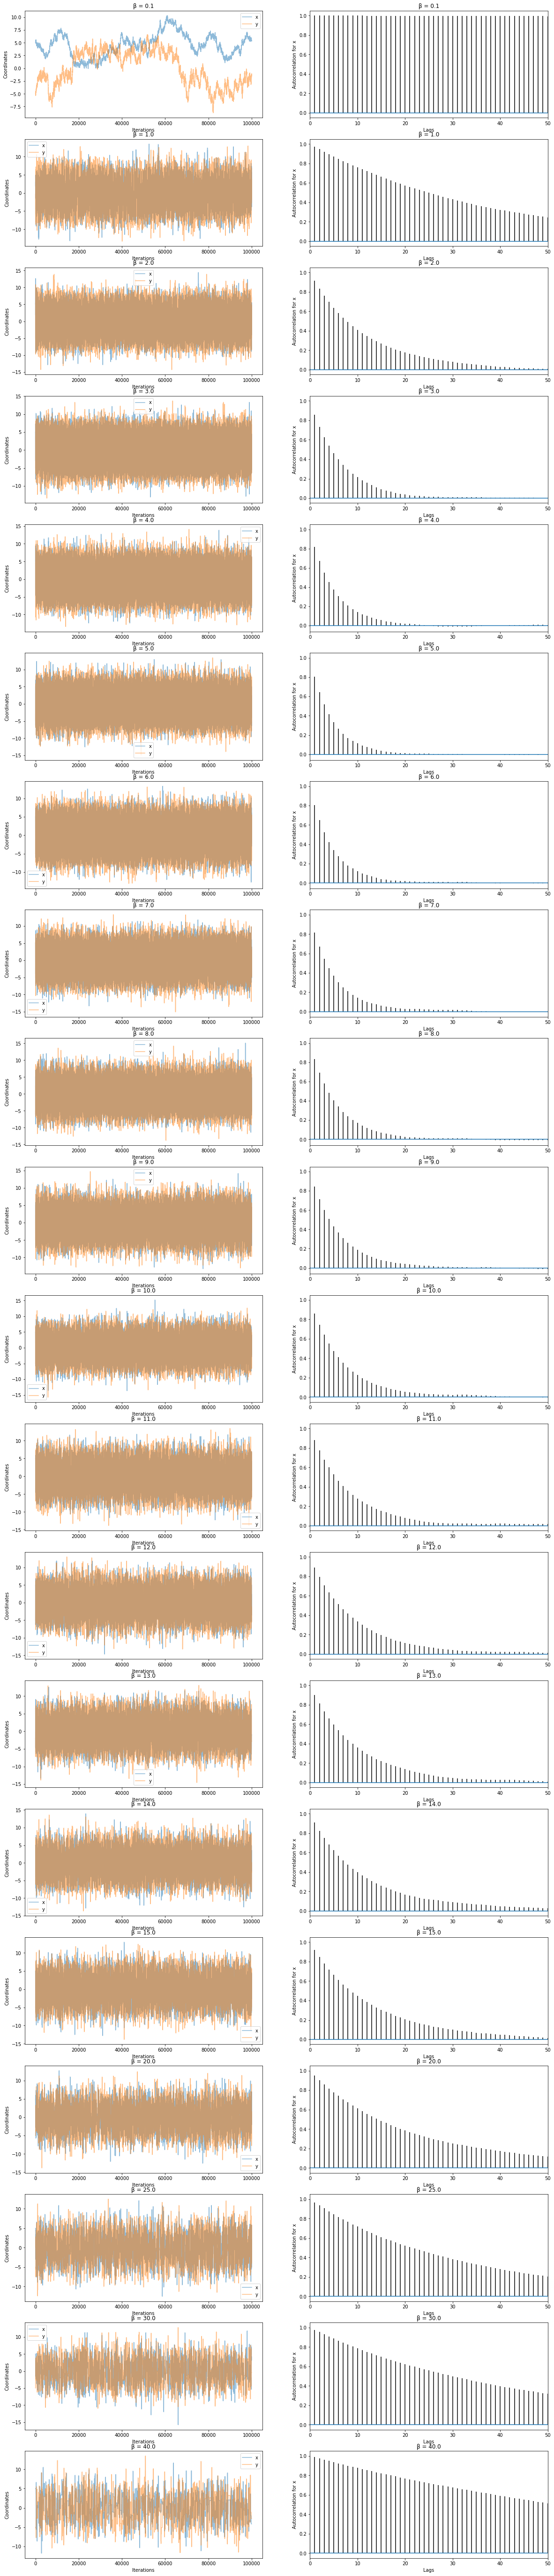

In [19]:
nrows = len(betas)
ncols = 2
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 10, nrows * 5))

for index, beta in enumerate(betas):
    MH_samples, accepted = metropolis_hastings(F, q, qdraw, nsamp, xinit, beta)
    accep_rate = accepted / nsamp
    
    print('beta = ', beta, ', acceptance rate = ', accep_rate)
    
    ax[index,0].plot(MH_samples[:,0], label='x', alpha=0.5)
    ax[index,0].plot(MH_samples[:,1], label='y', alpha=0.5)
    ax[index,0].set_xlabel('Iterations')
    ax[index,0].set_ylabel('Coordinates')
    ax[index,0].set_title('\u03B2 = ' + str(beta))
    ax[index,0].legend()
    
    ax[index,1].acorr(MH_samples[:,0] - np.mean(MH_samples[:,0]), normed=True, maxlags=50)
    ax[index,1].set_xlim(0, 50)
    ax[index,1].set_xlabel('Lags')
    ax[index,1].set_ylabel('Autocorrelation for x')
    ax[index,1].set_title('\u03B2 = ' + str(beta))
    
plt.show()

In terms of the trace plots, it seems that the samples converged for all $\beta$ values except for 0.1. This means that all $\beta$ values except for 0.1 are potentially good $\beta$ values. 

For $\beta = 0.1$, the acceptance rate is 0.2262. For $\beta = 1$, the acceptance rate is 0.7614, and after this beta value, the acceptance rates decrease as $\beta$ increases. The acceptance rate is below 0.3 for $\beta > 5$. This narrows the range of $\beta$ to $[1, 5]$. 

The autocorrelation plots for these $\beta$ values show that the samples are least autocorrelated for $\beta = 5$ with the autocorrelation values decreasing fastest to 0. Therefore, the best $\beta$ value is 5.

### Part C

In [20]:
def qdraw(x, beta):
    gamma1 = beta
    gamma2 = 1.5 * beta
    Sigma = np.array([[gamma1**2, 0], [0, gamma2**2]])
    draw = np.random.multivariate_normal(mean=x, cov=Sigma, size=1)
    return draw

In [21]:
def q(x_star, x_prev, beta):
    gamma1 = beta
    gamma2 = 1.5 * beta
    Sigma = np.array([[gamma1**2, 0], [0, gamma2**2]])
    pdf = multivariate_normal.pdf(x_star, mean=x_prev, cov=Sigma)
    return pdf

beta =  0.1 , acceptance rate =  0.96989
beta =  1.0 , acceptance rate =  0.77521
beta =  2.0 , acceptance rate =  0.63667
beta =  3.0 , acceptance rate =  0.52707
beta =  4.0 , acceptance rate =  0.42935
beta =  5.0 , acceptance rate =  0.35141
beta =  6.0 , acceptance rate =  0.28572
beta =  7.0 , acceptance rate =  0.23289
beta =  8.0 , acceptance rate =  0.19604
beta =  9.0 , acceptance rate =  0.1638
beta =  10.0 , acceptance rate =  0.13684
beta =  11.0 , acceptance rate =  0.11941
beta =  12.0 , acceptance rate =  0.10253
beta =  13.0 , acceptance rate =  0.08859
beta =  14.0 , acceptance rate =  0.07957
beta =  15.0 , acceptance rate =  0.06922
beta =  20.0 , acceptance rate =  0.04043
beta =  25.0 , acceptance rate =  0.02593
beta =  30.0 , acceptance rate =  0.01907
beta =  40.0 , acceptance rate =  0.01066


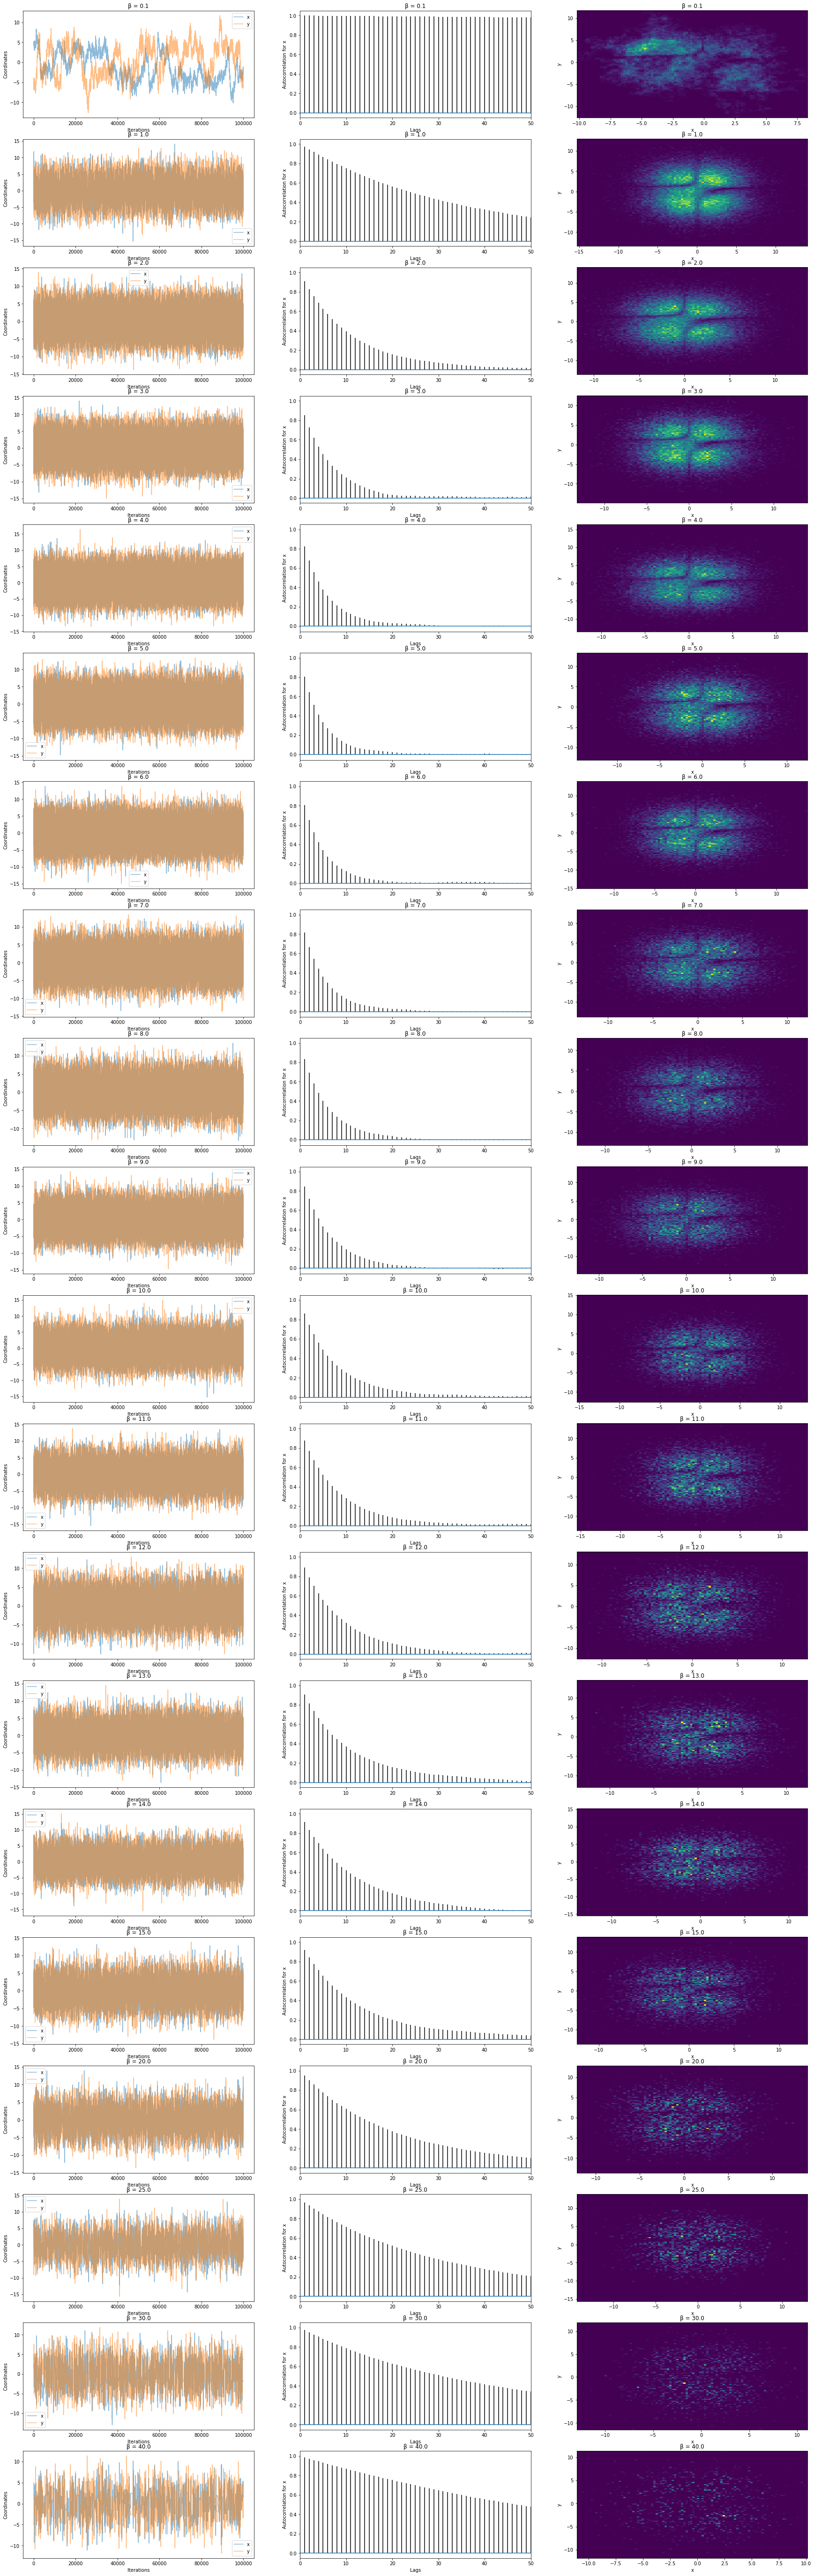

In [30]:
ncols = 3
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 10, nrows * 5))

for index, beta in enumerate(betas):
    MH_samples, accepted = metropolis_hastings(F, q, qdraw, nsamp, xinit, beta)
    accep_rate = accepted / nsamp
    
    print('beta = ', beta, ', acceptance rate = ', accep_rate)
    
    ax[index,0].plot(MH_samples[:,0], label='x', alpha=0.5)
    ax[index,0].plot(MH_samples[:,1], label='y', alpha=0.5)
    ax[index,0].set_xlabel('Iterations')
    ax[index,0].set_ylabel('Coordinates')
    ax[index,0].set_title('\u03B2 = ' + str(beta))
    ax[index,0].legend()
    
    ax[index,1].acorr(MH_samples[:,0] - np.mean(MH_samples[:,0]), normed=True, maxlags=50)
    ax[index,1].set_xlim(0, 50)
    ax[index,1].set_xlabel('Lags')
    ax[index,1].set_ylabel('Autocorrelation for x')
    ax[index,1].set_title('\u03B2 = ' + str(beta))
    
    ax[index,2].hist2d(MH_samples[:,0], MH_samples[:,1], bins=100)
    ax[index,2].set_xlabel('x')
    ax[index,2].set_ylabel('y')
    ax[index,2].set_title('\u03B2 = ' + str(beta))
    
plt.show()

The 2D histograms for $\beta$ values between 1 and 6 are comparable to the 2D histogram in Part A. The other histograms are more sparse than the histogram in Part A.

The trace plots for both Part B and Part C are very similar. It seems that the samples converged for all values except for $\beta = 0.1$.

The acceptance rate for $\beta = 0.1$ is higher in Part C. The acceptance rates for the other $\beta$ values are similar. When $\beta$ is low, the pdf ratios will tend to be close to 1 because we're our proposals from the bivariate normal distribution are very close together due to a low $\beta$ value which governs our variance. 

Overall, the autocorrelations plots are similar to the autocorrelation plots in Part B. These plots suggest that $\beta$ values between 4 and 9 are reasonable. 

Since $\beta = 4$ has a higher acceptance rate than $\beta = 5$ and the acceptance rates for $\beta > 5$ are less than 0.3, the best $\beta$ value is 4.